In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from matplotlib.ticker import LogLocator
from matplotlib.lines import Line2D
import glob
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import os
import pandas as pd
from scipy.ndimage import zoom

### DISK ANALYSIS

In [2]:
def merge_subregions(filename, rows, cols, overlap, size):

    ef_size = size - overlap
    merged_size_x = ef_size * rows + overlap
    merged_size_y = ef_size * cols + overlap
    merged_array = np.zeros((merged_size_x, merged_size_y, 9))

    for i in range(rows):
        for j in range(cols):
            subregion_filename = f'{filename}_{i}{j}.fits'
            subregion_data = fits.open(subregion_filename)[0].data
            x_start = i * ef_size
            y_start = j * ef_size
            merged_array[x_start:x_start+size, y_start:y_start+size] = subregion_data

    return merged_array

filename = 'spc_disk_part'
rows = 3
cols = 3  
overlap = 4
size = 132

spc_center = merge_subregions(filename, rows, cols, overlap, size)
print(spc_center.shape)

(388, 388, 9)


In [4]:
ptp_center = fits.open('center_ptp_full.fits')[0].data[:388,:388]
spr_center = fits.open('center_spr_full.fits')[0].data[0][:388,:388]
atmos_center = fits.open('qs_ph_disk_center.fits')[0].data[:,:,:388,:388]

atmos_center[5] /= 1e5

In [5]:
Bz_ptp = ptp_center[:,:,0]*np.cos(np.radians(ptp_center[:,:,1]))
Bz_spc = spc_center[:,:,0]*np.cos(np.radians(spc_center[:,:,1]))
Bz_spr = spr_center[:,:,0]*np.cos(np.radians(spr_center[:,:,1]))
Bz_spc = spc_center[:,:,0]*np.cos(np.radians(spc_center[:,:,1]))

vlos_ptp = ptp_center[:,:,3]
vlos_spc = spc_center[:,:,3]
vlos_spr = spr_center[:,:,3]
vlos_spc = spc_center[:,:,3]

### Magnetic field 

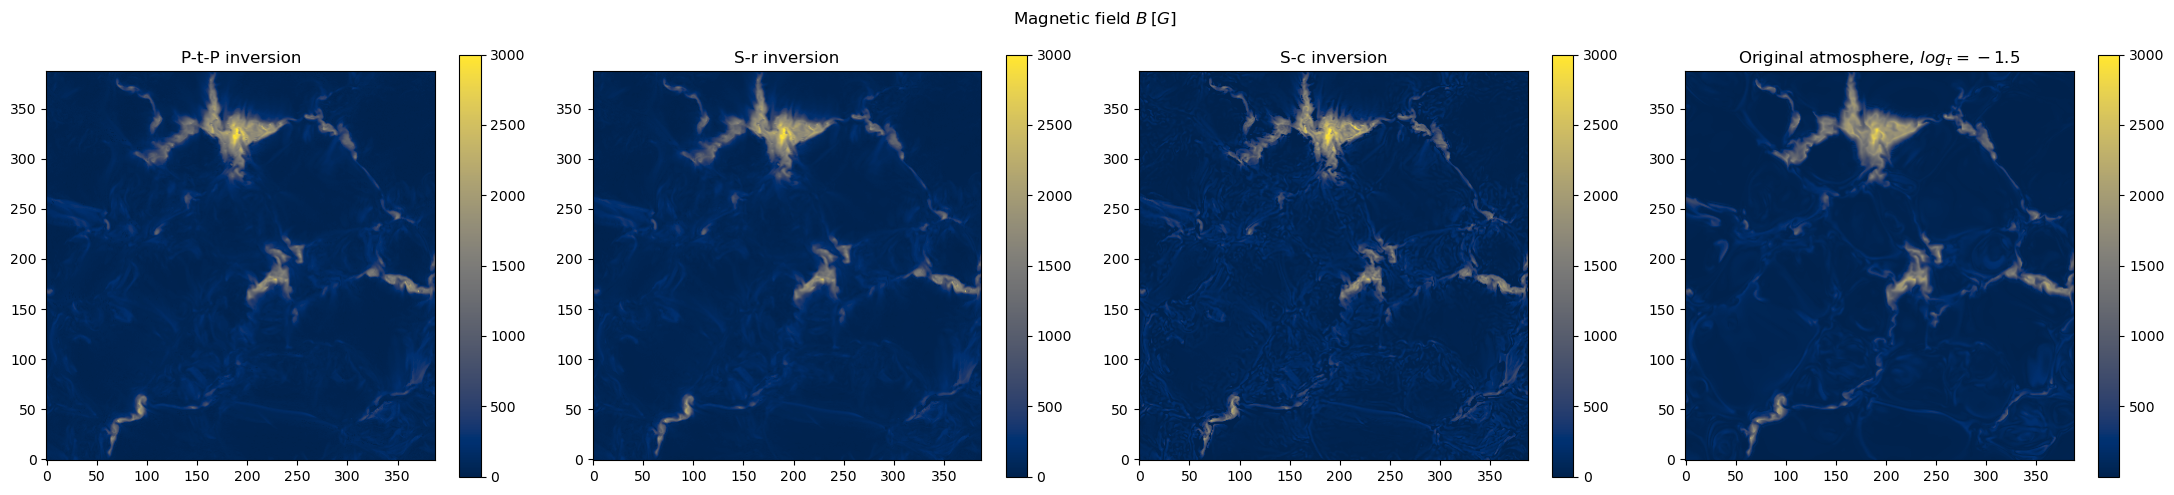

In [6]:
plt.figure(figsize=(22,5)) 
plt.subplot(141)
plt.imshow(Bz_ptp, cmap='cividis', origin='lower', vmax=3000)
plt.colorbar()
plt.title(r'P-t-P inversion')

plt.subplot(142)
plt.imshow(Bz_spr, cmap='cividis', origin='lower', vmax=3000)
plt.colorbar()
plt.title(r'S-r inversion')

plt.subplot(143)
plt.imshow(Bz_spc, cmap='cividis', origin='lower', vmax=3000)
plt.colorbar()
plt.title(r'S-c inversion')
          
plt.subplot(144)
plt.imshow(atmos_center[4, 30].T, cmap='cividis', origin='lower', vmax=3000)
plt.colorbar()
plt.title(r'Original atmosphere, $log_{\tau}=-1.5$')

plt.suptitle('Magnetic field $B\,[G]$')
plt.tight_layout()     
plt.show()

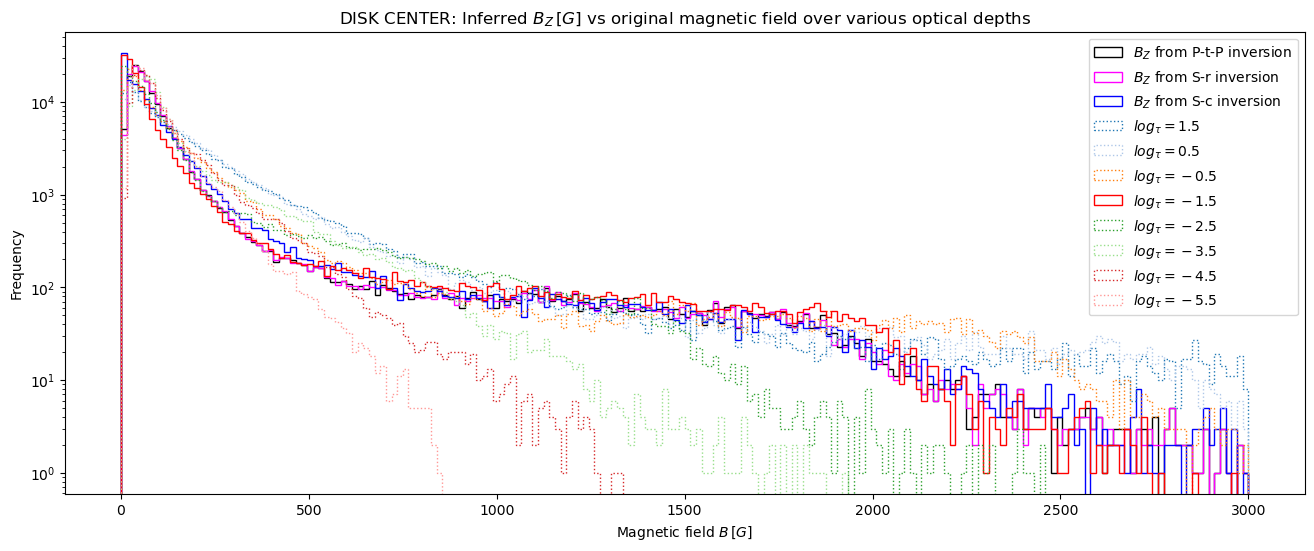

In [7]:
od_center = atmos_center[0,:,0,0]
num_bins = 200
ran = (0,3000)
cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(len(od_center) // 10 + 1)]
plt.figure(figsize=(16, 6))

plt.hist(Bz_ptp.ravel(), num_bins, color='black',
         label=r'$B_Z$ from P-t-P inversion', histtype='step', range=ran)
plt.hist(Bz_spr.ravel(), num_bins, color='magenta',
         label=r'$B_Z$ from S-r inversion', histtype='step', range=ran)
plt.hist(Bz_spc.ravel(), num_bins, color='blue',
         label=r'$B_Z$ from S-c inversion', histtype='step', range=ran)

for idx, i in enumerate(range(0, len(od_center), 10)):
    depth_value = od_center[i]
    linestyle = '-' if i == 30 else ':'
    color = 'red' if i == 30 else colors[idx % len(colors)]
    plt.hist((atmos_center[4, i].T).ravel(), num_bins, histtype='step', linestyle=linestyle, color=color,
             range=ran, label=f'$log_τ= {depth_value}$')

plt.title(r'DISK CENTER: Inferred $B_Z\,[G]$ vs original magnetic field over various optical depths')
plt.xlabel(r'Magnetic field $B\,[G]$')
plt.ylabel(r'Frequency')
plt.yscale('log')  

plt.legend()
plt.grid(False)
plt.show()

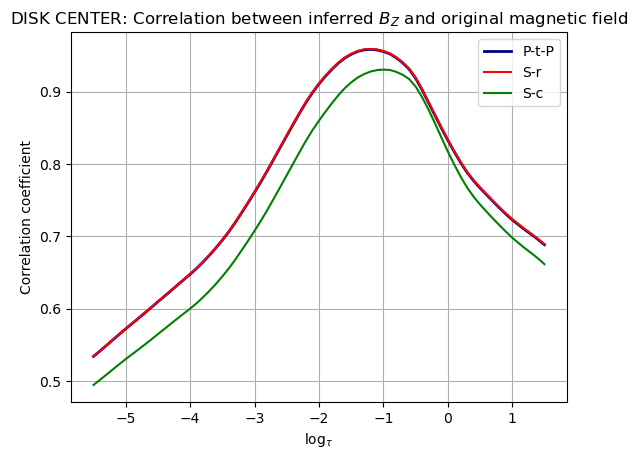

In [8]:
cc_B_1 = []
cc_B_2 = []
cc_B_3 = []

for i in range(len(od_center)):
    
    crl_1 = np.corrcoef((atmos_center[4,i].T).flatten(), Bz_ptp.flatten())[0, 1]
    cc_B_1.append(crl_1)
    crl_2 = np.corrcoef((atmos_center[4,i].T).flatten(), Bz_spr.flatten())[0, 1]
    cc_B_2.append(crl_2)
    crl_3 = np.corrcoef((atmos_center[4,i].T).flatten(), Bz_spc.flatten())[0, 1]
    cc_B_3.append(crl_3)

plt.plot(od_center, cc_B_1, color='navy', label='P-t-P', linewidth=2)
plt.plot(od_center, cc_B_2, color='red', label='S-r')
plt.plot(od_center, cc_B_3, color='green', label='S-c')
plt.xlabel(r'$\log_{\tau}$')
plt.ylabel('Correlation coefficient')
plt.title('DISK CENTER: Correlation between inferred $B_Z$ and original magnetic field')
plt.legend()
plt.grid()
plt.show()

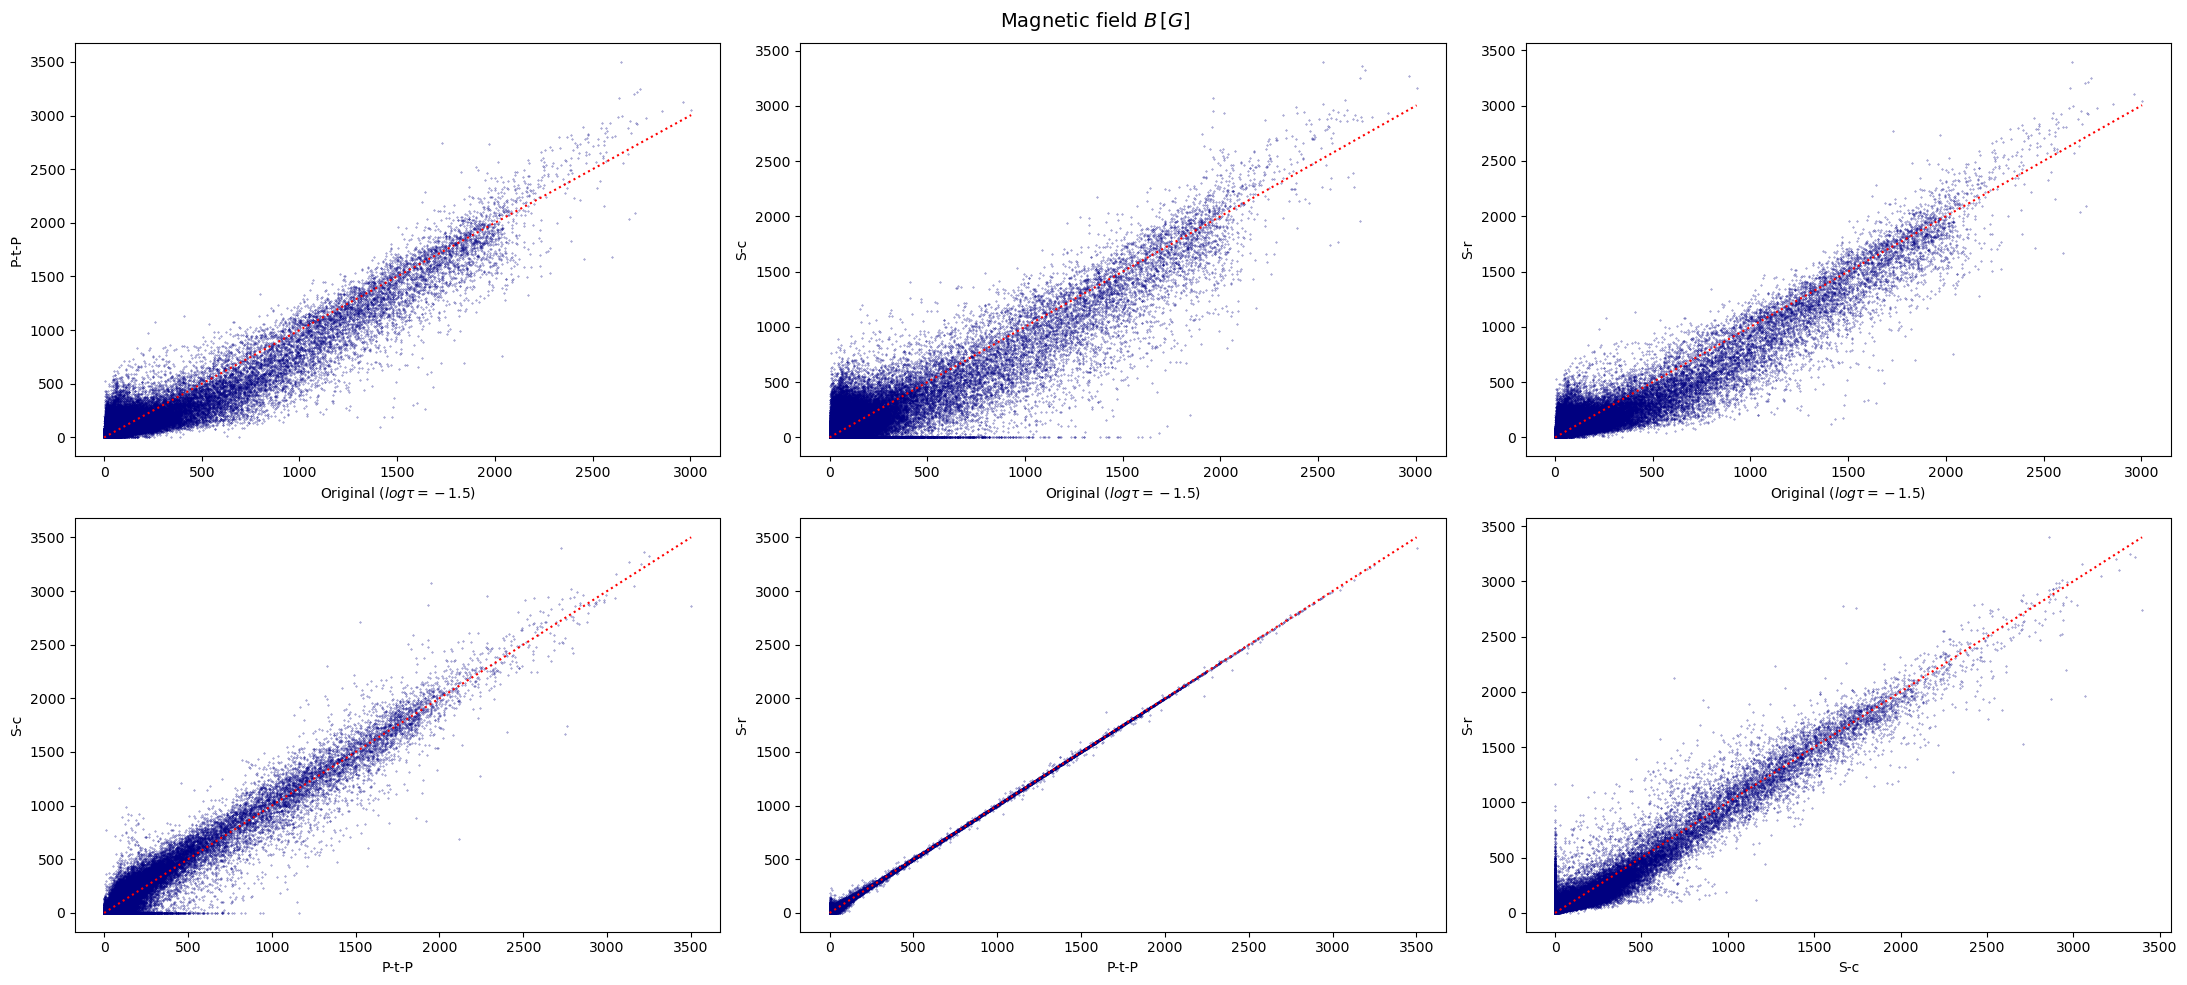

In [9]:
scatter_plots = [
    ((atmos_center[4, 30].T).ravel(), Bz_ptp.ravel(), r"Original ($logτ=-1.5$) vs P-t-P"),
    ((atmos_center[4, 30].T).ravel(), Bz_spc.ravel(), r"Original ($logτ=-1.5$) vs S-c"),
    ((atmos_center[4, 30].T).ravel(), Bz_spr.ravel(), r"Original ($logτ=-1.5$)  vs S-r"),
   # (atmos_center[4, 30].ravel(), Bz_ptp_cnv.ravel(), r"Original ($logτ=-1.5$) vs P-t-P-C"),
    (Bz_ptp.ravel(), Bz_spc.ravel(), r"P-t-P vs S-c"),
    (Bz_ptp.ravel(), Bz_spr.ravel(), r"P-t-P vs S-r"),
   # (Bz_ptp.ravel(), Bz_ptp_cnv.ravel(), r"P-t-P vs P-t-P-C"),
    (Bz_spc.ravel(), Bz_spr.ravel(), r"S-c vs S-r"),
   # (Bz_spc.ravel(), Bz_ptp_cnv.ravel(), r"S-C vs P-t-P-C"),
   # (Bz_spr.ravel(), Bz_ptp_cnv.ravel(), r"S-R vs P-t-P-C"),
]

fig, axes = plt.subplots(2, 3, figsize=(22, 10))
axes = axes.flatten()

for idx, (x, y, title) in enumerate(scatter_plots):
    ax = axes[idx]
    ax.scatter(x, y, s=0.1, alpha=0.7, color='navy')
    ax.plot([x.min(), x.max()], [x.min(), x.max()], color='red', linestyle=':')
    ax.set_xlabel(f'{title.split(" vs ")[0]}')  
    ax.set_ylabel(f'{title.split(" vs ")[1]}') 

plt.suptitle(r'Magnetic field $B\,[G]$', fontsize=14)
plt.tight_layout()
plt.show()

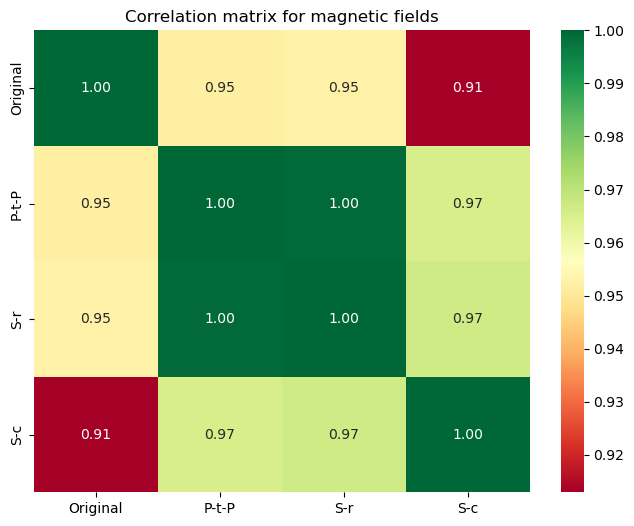

In [10]:
correlation_matrix = np.corrcoef([(atmos_center[4,30].T).ravel(), 
                    Bz_ptp.ravel(), Bz_spr.ravel(), Bz_spc.ravel()])

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['Original', 'P-t-P', 'S-r', 'S-c'],
            yticklabels=['Original', 'P-t-P', 'S-r', 'S-c'])
plt.title('Correlation matrix for magnetic fields')
plt.show()

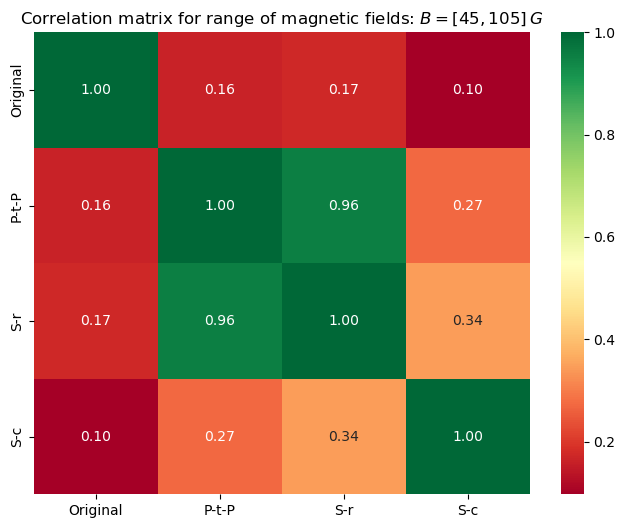

In [11]:
Bmin = 45
Bmax = 105

combined_mask = ((Bz_ptp >= Bmin) & (Bz_ptp <= Bmax) &
                 (Bz_spr >= Bmin) & (Bz_spr <= Bmax) &
                 (Bz_spc >= Bmin) & (Bz_spc <= Bmax) &
                 (atmos_center[4, 30].T >= Bmin) & (atmos_center[4, 30].T <= Bmax))

correlation = [mask[combined_mask].ravel() for mask in [atmos_center[4, 30].T, Bz_ptp, Bz_spr, Bz_spc]]

correlation_matrix = np.corrcoef(correlation)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['Original', 'P-t-P', 'S-r', 'S-c'],
            yticklabels=['Original', 'P-t-P', 'S-r', 'S-c'])
plt.title(fr'Correlation matrix for range of magnetic fields: $B= [{Bmin}, {Bmax}]\,G$')
plt.show()

### LOS velocity

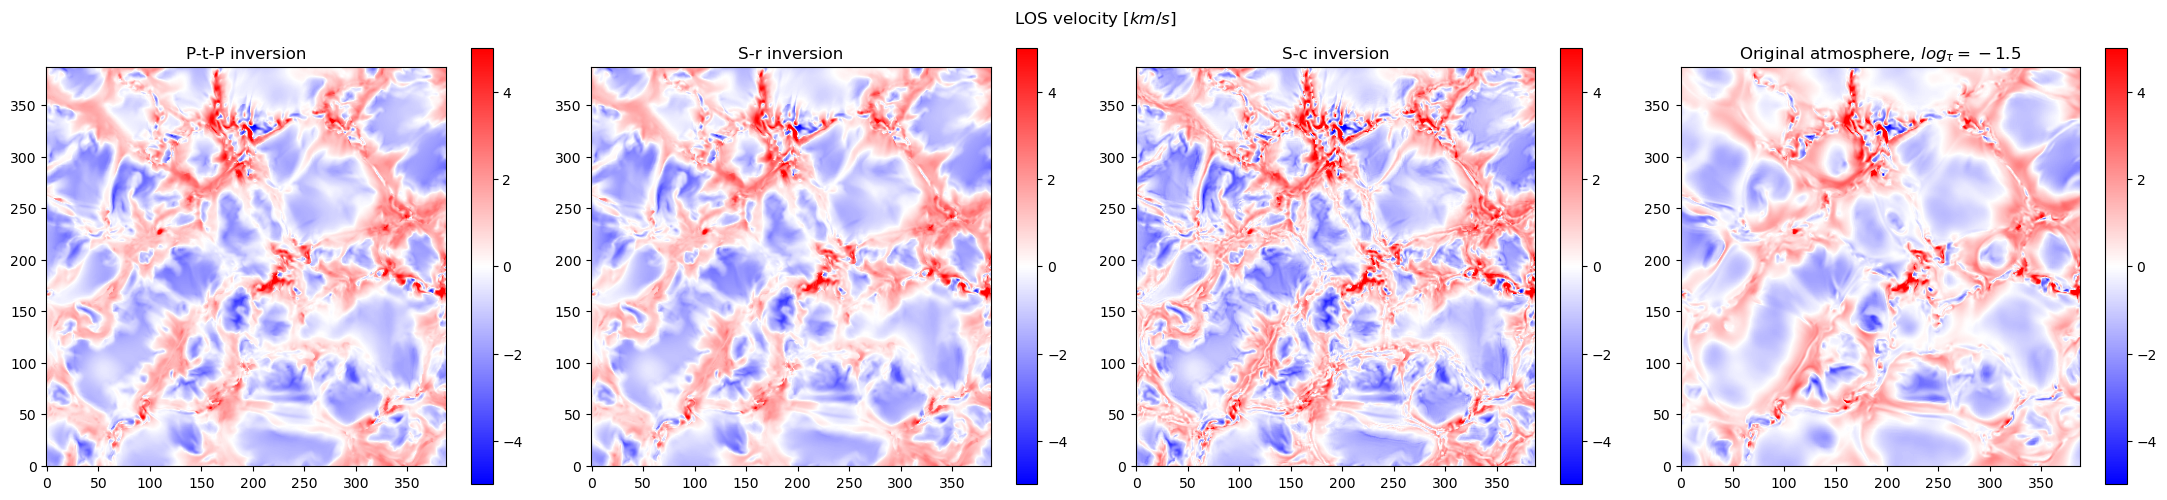

In [197]:
plt.figure(figsize=(22, 5))

plt.subplot(141)
plt.imshow(vlos_ptp, cmap='bwr', origin='lower', vmin=-5, vmax=5)
plt.colorbar()
plt.title(r'P-t-P inversion')

plt.subplot(142)
plt.imshow(vlos_spr, cmap='bwr', origin='lower', vmin=-5, vmax=5)
plt.colorbar()
plt.title(r'S-r inversion')

plt.subplot(143)
plt.imshow(vlos_spc, cmap='bwr', origin='lower', vmin=-5, vmax=5)
plt.colorbar()
plt.title(r'S-c inversion')
          
plt.subplot(144)
plt.imshow(atmos_center[5, 30].T, cmap='bwr', origin='lower', vmin=-5, vmax=5)
plt.colorbar()
plt.title(r'Original atmosphere, $log_{\tau}=-1.5$')

plt.suptitle('LOS velocity $[km/s]$')
plt.tight_layout()     
plt.show()

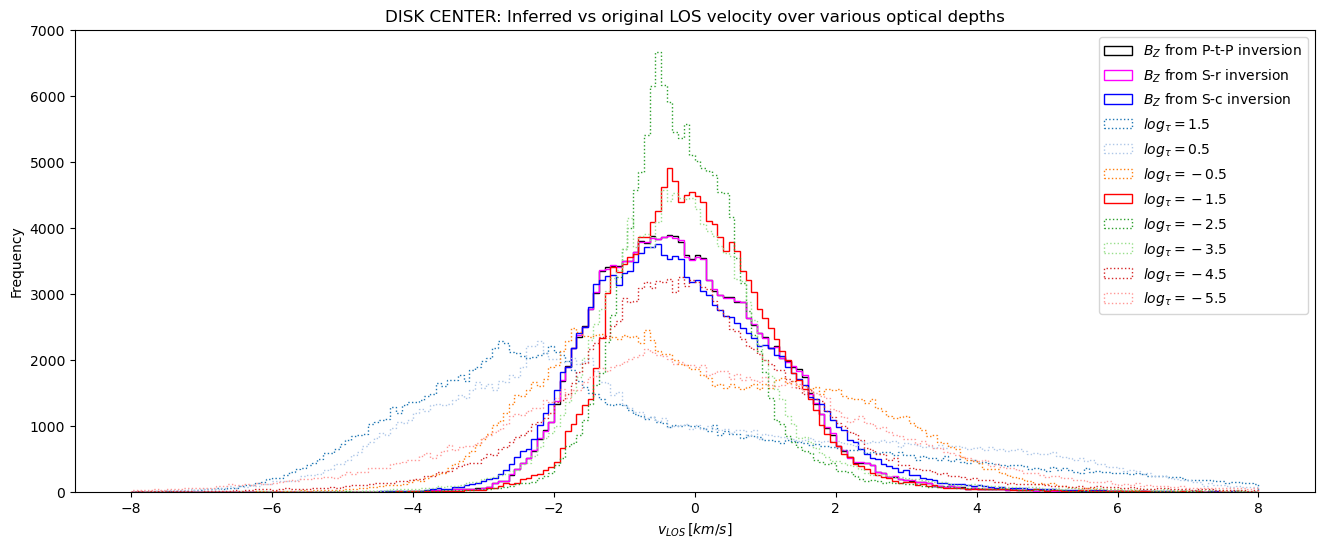

In [12]:
od_center = atmos_center[0,:,0,0]
num_bins = 200
ran =(-8,8)

cmap = plt.get_cmap("tab20")
colors = [cmap(i) for i in range(len(od_center) // 10 + 1)]
plt.figure(figsize=(16, 6))

plt.hist(vlos_ptp.ravel(), num_bins, color='black',
         label=r'$B_Z$ from P-t-P inversion', histtype='step', range=ran)
plt.hist(vlos_spr.ravel(), num_bins, color='magenta',
         label=r'$B_Z$ from S-r inversion', histtype='step', range=ran)
plt.hist(vlos_spc.ravel(), num_bins, color='blue',
         label=r'$B_Z$ from S-c inversion', histtype='step', range=ran)

for idx, i in enumerate(range(0, len(od_center), 10)):
    depth_value = od_center[i]
    linestyle = '-' if i == 30 else ':'
    color = 'red' if i == 30 else colors[idx % len(colors)]
    plt.hist(atmos_center[5, i].ravel(), num_bins, histtype='step', linestyle=linestyle, color=color,
              range=ran, label=f'$log_τ= {depth_value}$')

plt.title(r'DISK CENTER: Inferred vs original LOS velocity over various optical depths')
plt.xlabel(r'$v_{LOS}\,[km/s]$')
plt.ylabel(r'Frequency')

plt.legend()
plt.grid(False)
plt.show()

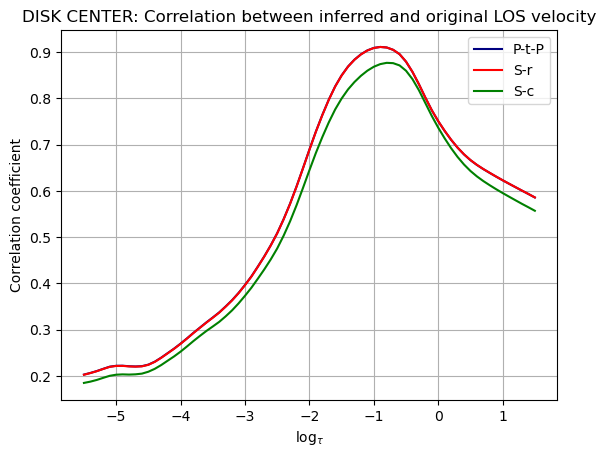

In [13]:
cc_v_1 = []
cc_v_2 = []
cc_v_3 = []

for i in range(len(od_center)):
    
    crl_1 = np.corrcoef((atmos_center[5,i].T).flatten(), vlos_ptp.flatten())[0, 1]
    cc_v_1.append(crl_1)
    crl_2 = np.corrcoef((atmos_center[5,i].T).flatten(), vlos_spr.flatten())[0, 1]
    cc_v_2.append(crl_2)
    crl_3 = np.corrcoef((atmos_center[5,i].T).flatten(), vlos_spc.flatten())[0, 1]
    cc_v_3.append(crl_3)

plt.plot(od_center, cc_v_1, color='navy', label='P-t-P')
plt.plot(od_center, cc_v_2, color='red', label='S-r')
plt.plot(od_center, cc_v_3, color='green', label='S-c')
plt.xlabel(r'$\log_{\tau}$')
plt.ylabel('Correlation coefficient')
plt.title('DISK CENTER: Correlation between inferred and original LOS velocity')
plt.legend()
plt.grid()
plt.show()

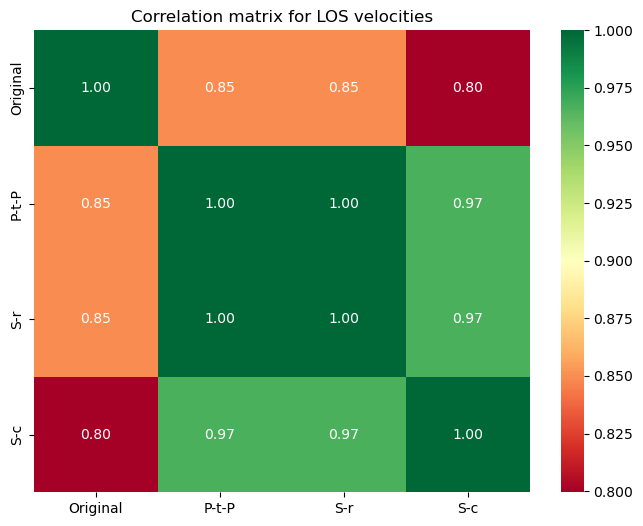

In [14]:
correlation_matrix = np.corrcoef([(atmos_center[5,30].T).ravel(), 
                    vlos_ptp.ravel(), vlos_spr.ravel(), vlos_spc.ravel()])

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['Original', 'P-t-P', 'S-r', 'S-c'],
            yticklabels=['Original', 'P-t-P', 'S-r', 'S-c'])
plt.title('Correlation matrix for LOS velocities')
plt.show()

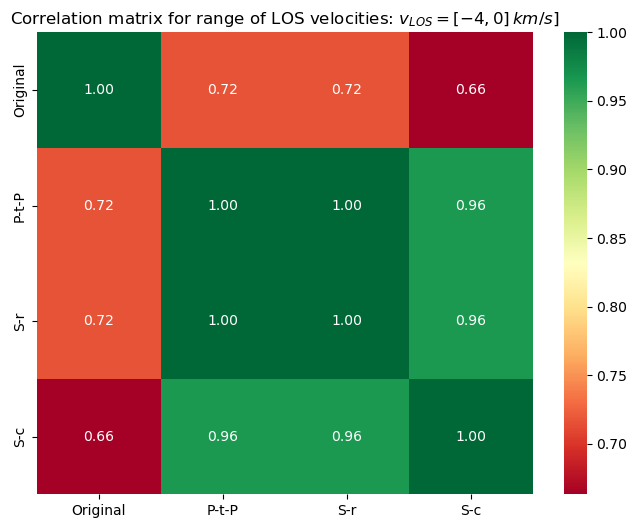

In [17]:
vmin = -4
vmax = 0

combined_mask = ((vlos_ptp >= vmin) & (vlos_ptp <= vmax) &
                 (vlos_spr >= vmin) & (vlos_spr <= vmax) &
                 (vlos_spc >= vmin) & (vlos_spc <= vmax) &
                 (atmos_center[5, 30].T >= vmin) & (atmos_center[5, 30].T <= vmax))

correlation = [mask[combined_mask].ravel() for mask in [atmos_center[5, 30].T, vlos_ptp, vlos_spr, vlos_spc]]

correlation_matrix = np.corrcoef(correlation)

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='RdYlGn',
            xticklabels=['Original', 'P-t-P', 'S-r', 'S-c'],
            yticklabels=['Original', 'P-t-P', 'S-r', 'S-c'])
plt.title(fr'Correlation matrix for range of LOS velocities: $v_{{LOS}}= [{vmin}, {vmax}]\,km/s$')
plt.show()